In [8]:
from matplotlib import pyplot as plt
import numpy as np
from figure_v3 import plot_sig
from eeg_v2 import EEG
from utils import chunks, baseline_calc, butter_bandpass_filter
import joblib
from mne.preprocessing import ICA

_scale_c = 9.0175556274876e-05

# Function and Lib

In [9]:
def _get_ica_map(ica, components=None):
    """Get ICA topomap for components"""
    fast_dot = np.dot
    if components is None:
        components = list(range(ica.n_components_))
    maps = fast_dot(ica.mixing_matrix_[:, components].T,
                    ica.pca_components_[:ica.n_components_])
    return maps

def get_chunks(sig):
    i = 0
    for task in sig.tasks:
        for c in chunks(task, 15):
            i+=1
            yield i, c
            
def count_chunks(sig):
    i = 0
    for task in sig.tasks:
        for c in chunks(task, 15):
            i+=1
    return i

In [10]:
# Reading raw data
path_edf="./edf/1578_alice/edf/A0001578.edf"
path_stage="./edf/1578_alice/csv/STAGE.csv"

eeg = EEG(path_edf=path_edf, path_stage=path_stage)

/home/tudo/Desktop/code/ica_paper/eeg_v2.py:17: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


In [11]:
# Preprocessing pipeline
def baseline_bandpass(chunk):
    sample_raw = eeg.raw.copy().crop(np.min(chunk),np.max(chunk),include_tmax=False)
    sample_raw_eog = eeg.eog_channels.copy().crop(np.min(chunk),np.max(chunk),include_tmax=False)


    # Baseline
    sample_raw_baseline = sample_raw.copy()
    sample_raw_baseline = sample_raw_baseline.apply_function(baseline_calc)

    # Bandpass
    sample_raw_bandpass = sample_raw_baseline.copy()
    sample_raw_bandpass = sample_raw_bandpass.apply_function(butter_bandpass_filter)
    
    return sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog

In [12]:
# ICA pipeline
def ica_pipe(sample_raw_bandpass):    
    clf = joblib.load("./models/eog_classifier_v2.joblib")


    sample_raw_train = sample_raw_bandpass.copy()
    sample_raw_corrected = sample_raw_bandpass.copy()

    # Fitting ICA
    ica = ICA(method="extended-infomax", random_state=1)
    ica.fit(sample_raw_corrected)

    maps = _get_ica_map(ica).T
    scalings = np.linalg.norm(maps, axis=0)
    maps /= scalings[None, :]
    X = maps.T

    # Predict EOG
    eog_preds = clf.predict(X)
    list_of_eog = np.where(eog_preds == 1)[0]
    
    # ica.plot_sources(inst=sample_raw_train) 
    # ica.plot_components(inst=sample_raw_train)

    ica.exclude = list_of_eog
    ica.apply(sample_raw_corrected)
    
    return ica, sample_raw_train, sample_raw_corrected

# FIGURE 2

## Raw + After baseline + bandpass

In [13]:
plt.rcParams["figure.figsize"] = [15,5]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


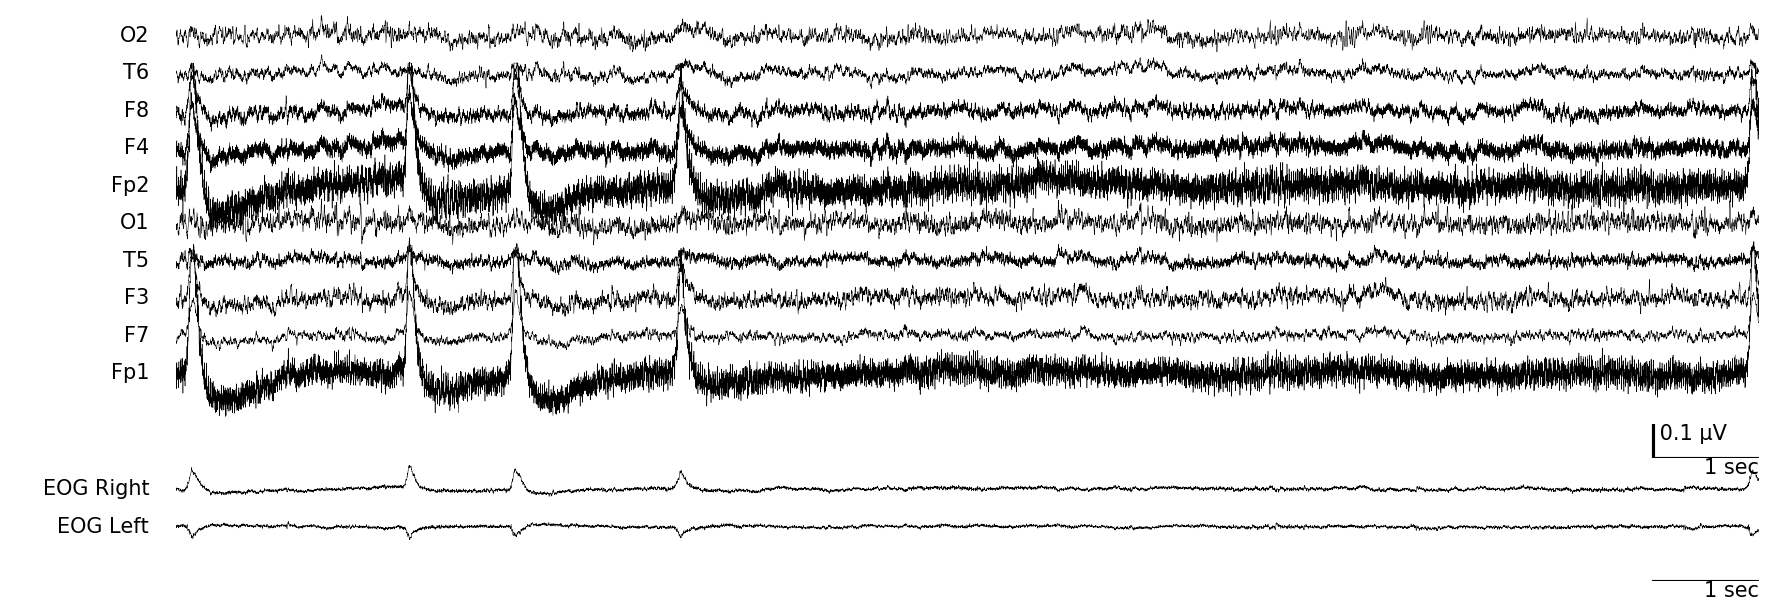

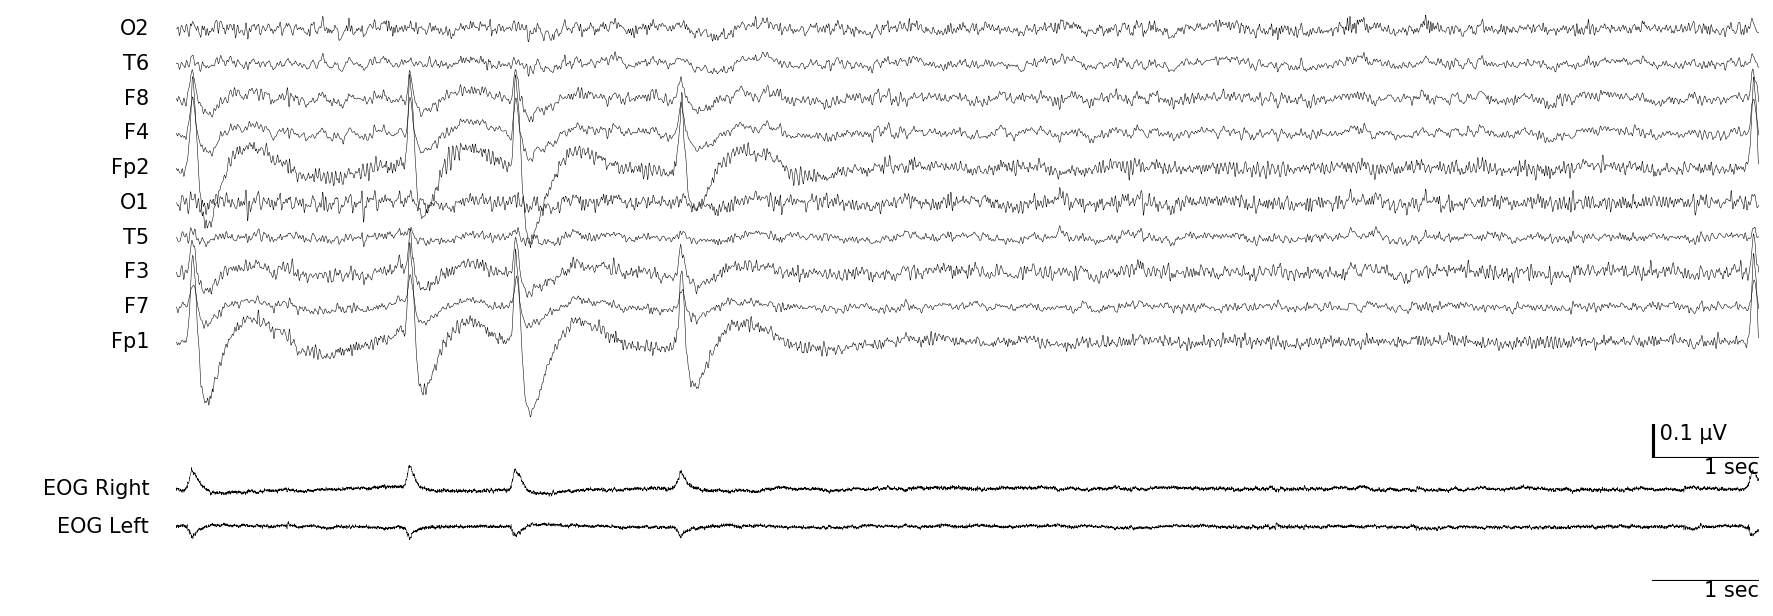

In [14]:
# plt.rcParams["figure.figsize"] = [10,5]
PATH = "figures/figure2"
i = 0
for task in eeg.tasks:
    for c in chunks(task, 15):
        i+=1
        
        if i!=7:
            continue
        
        if i>7:
            break
        
        sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog = baseline_bandpass(c)
        

        # Raw
        plot_sig(
            X = sample_raw.get_data() * 1e3,
            fs = 500,
            dpi = 150,
            unit = "μV",
            ch_names = sample_raw.ch_names,
            X_EOG = sample_raw_eog.get_data() * 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
            scale = _scale_c*1e3
        );
        

        # Baseline + Bandpass
        plot_sig(
            X = sample_raw_bandpass.get_data() * 1e3,
            fs = 500,
            dpi = 150,
            unit = "μV",
            ch_names = sample_raw.ch_names,
            X_EOG = sample_raw_eog.get_data() * 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
            markers = [.3,2.2,3.3,4.9],
            scale = _scale_c*1e3

        );

# FIGURE 3

## Good example

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Inferring max_pca_components from picks


<ipython-input-12-9f71c3044bd4>:10: DeprecationWarning: method='extended-infomax' is deprecated and will be removed in 0.19. If you want to use Extended Infomax, specify method='infomax' together with fit_params=dict(extended=True).
  ica = ICA(method="extended-infomax", random_state=1)


Using all PCA components: 10
Computing Extended Infomax ICA
Fitting ICA took 3.5s.
Transforming to ICA space (10 components)
Zeroing out 1 ICA components


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


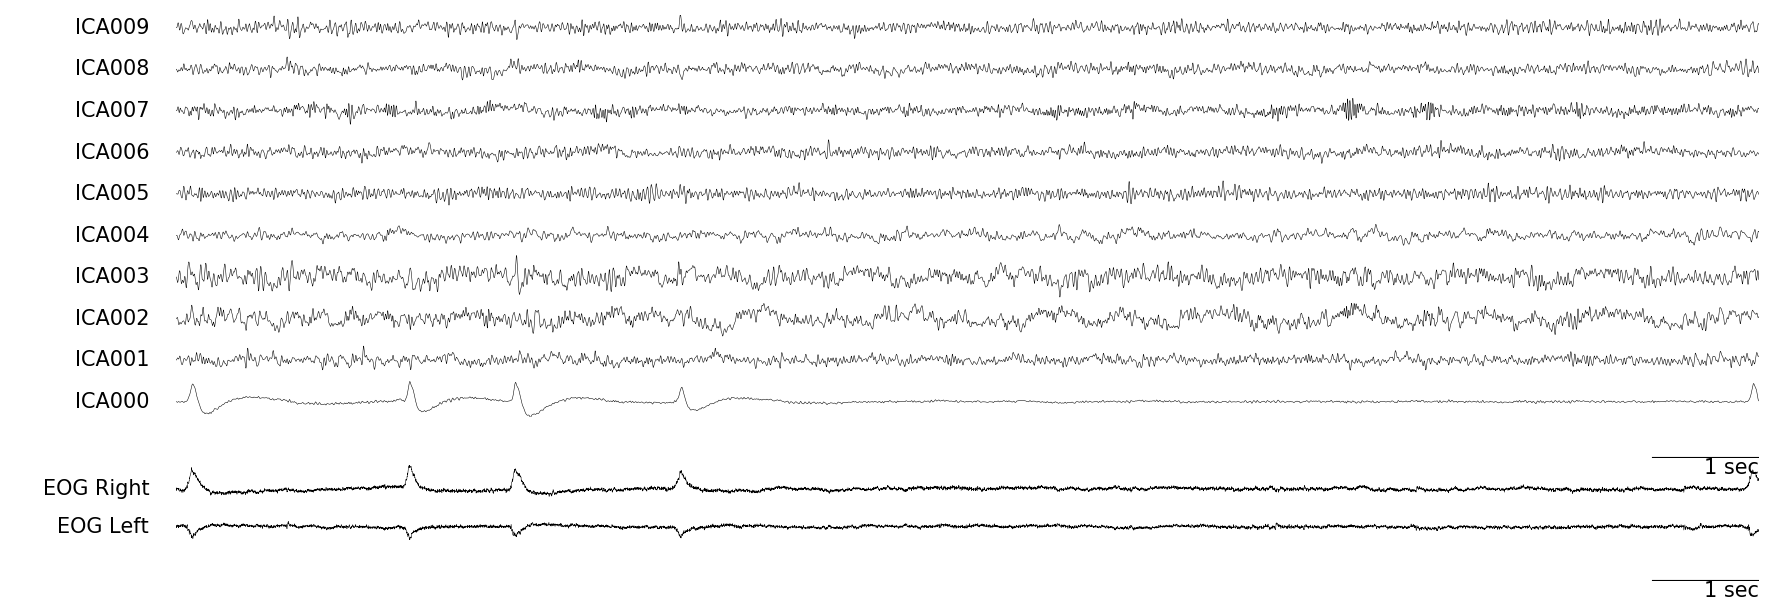

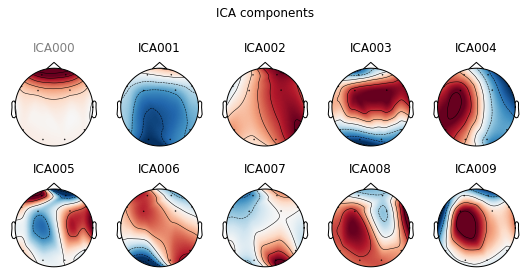

In [15]:
i = 0
PATH = "figures/figure3"
for task in eeg.tasks:
    for c in chunks(task, 15):
        i+=1
        if i!=7:
            continue
        
        if i>7:
            break
        
            
        sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog = baseline_bandpass(c)
        ica, sample_raw_train, sample_raw_corrected = ica_pipe(sample_raw_bandpass)
        
        # Save fig
        plot_sig(
            X = ica.get_sources(inst=sample_raw_train).get_data() * 1e3,
            fs = 500,
            dpi = 150,
#             unit = "μV",
            ch_names = ica.get_sources(inst=sample_raw_train).ch_names,
            X_EOG = sample_raw_eog.get_data() * 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
        );
        
        ica.plot_components(inst=sample_raw_train)

## Bad example

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 10
Computing Extended Infomax ICA


<ipython-input-12-9f71c3044bd4>:10: DeprecationWarning: method='extended-infomax' is deprecated and will be removed in 0.19. If you want to use Extended Infomax, specify method='infomax' together with fit_params=dict(extended=True).
  ica = ICA(method="extended-infomax", random_state=1)


Fitting ICA took 2.3s.
Transforming to ICA space (10 components)
Zeroing out 2 ICA components


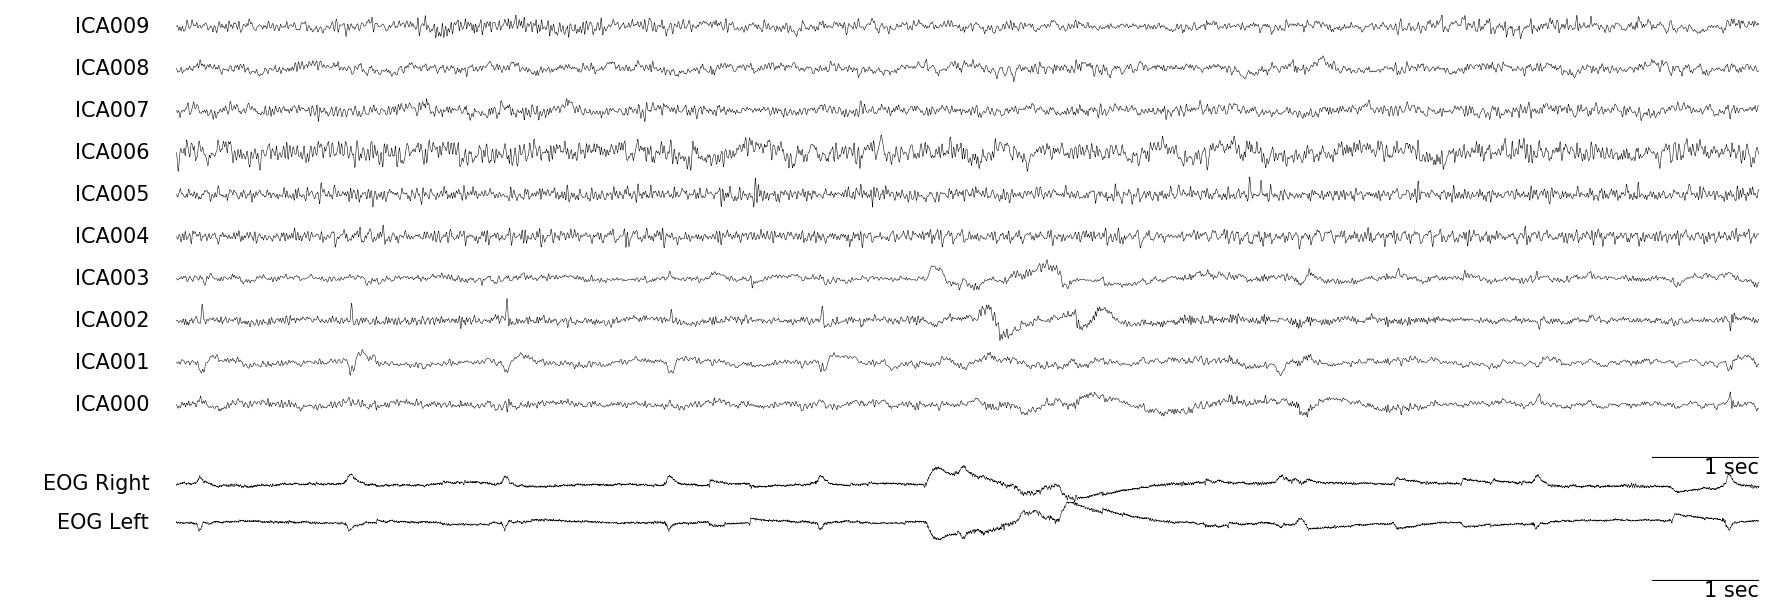

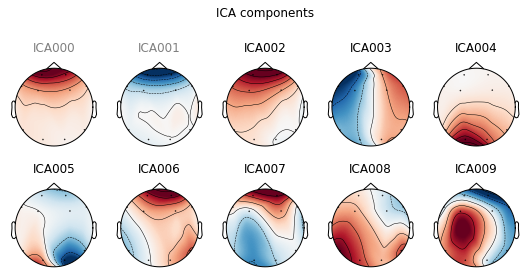

In [19]:
i = 0
PATH = "figures/figure3"
for task in eeg.tasks:
    for c in chunks(task, 15):
        i+=1
        if i!=50:
            continue
        
        if i>50:
            break
        
            
        sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog = baseline_bandpass(c)
        ica, sample_raw_train, sample_raw_corrected = ica_pipe(sample_raw_bandpass)
        
        # Save fig
        plot_sig(
            X = ica.get_sources(inst=sample_raw_train).get_data() * 1e3,
            fs = 500,
            dpi = 150,
#             unit = "μV",
            ch_names = ica.get_sources(inst=sample_raw_train).ch_names,
            X_EOG = sample_raw_eog.get_data() * 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
        );
        
        ica.plot_components(inst=sample_raw_train)

# Figure 4

## Before ICA (Bandpass + Baseline)

In [16]:
# _scale_after = np.max(sample_raw_corrected.get_data()) - np.min(sample_raw_corrected.get_data())
# _scale_after

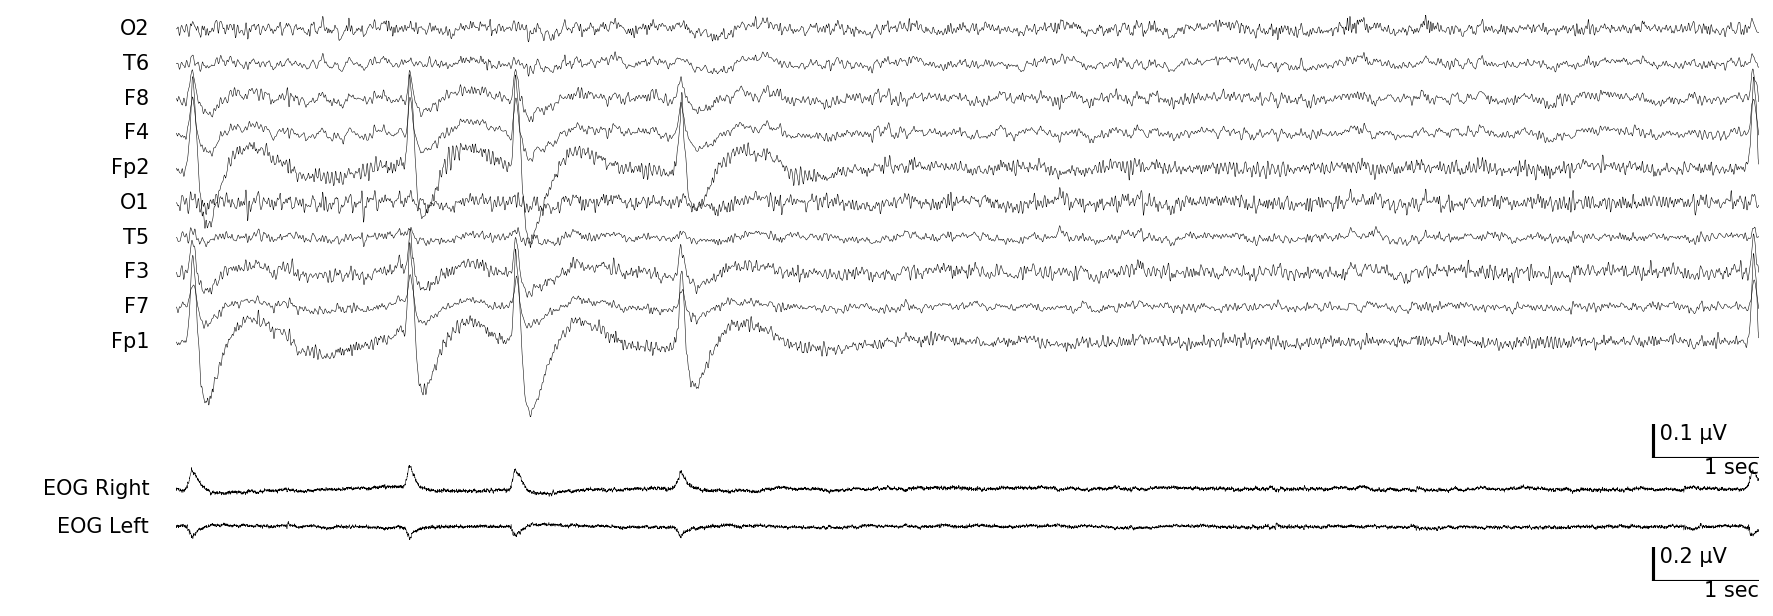

In [17]:
plot_sig(
    X = sample_raw_bandpass.get_data() * 1e3,
    fs = 500,
    dpi = 150,
    unit = "μV",
    ch_names = sample_raw_corrected.ch_names,
    X_EOG = sample_raw_eog.get_data() * 1e3,
    eog_ch_names = sample_raw_eog.ch_names,
    markers = [.3,2.2,3.3,4.9],
    eog_unit="μV",
    scale=_scale_c*1e3
);

## After ICA

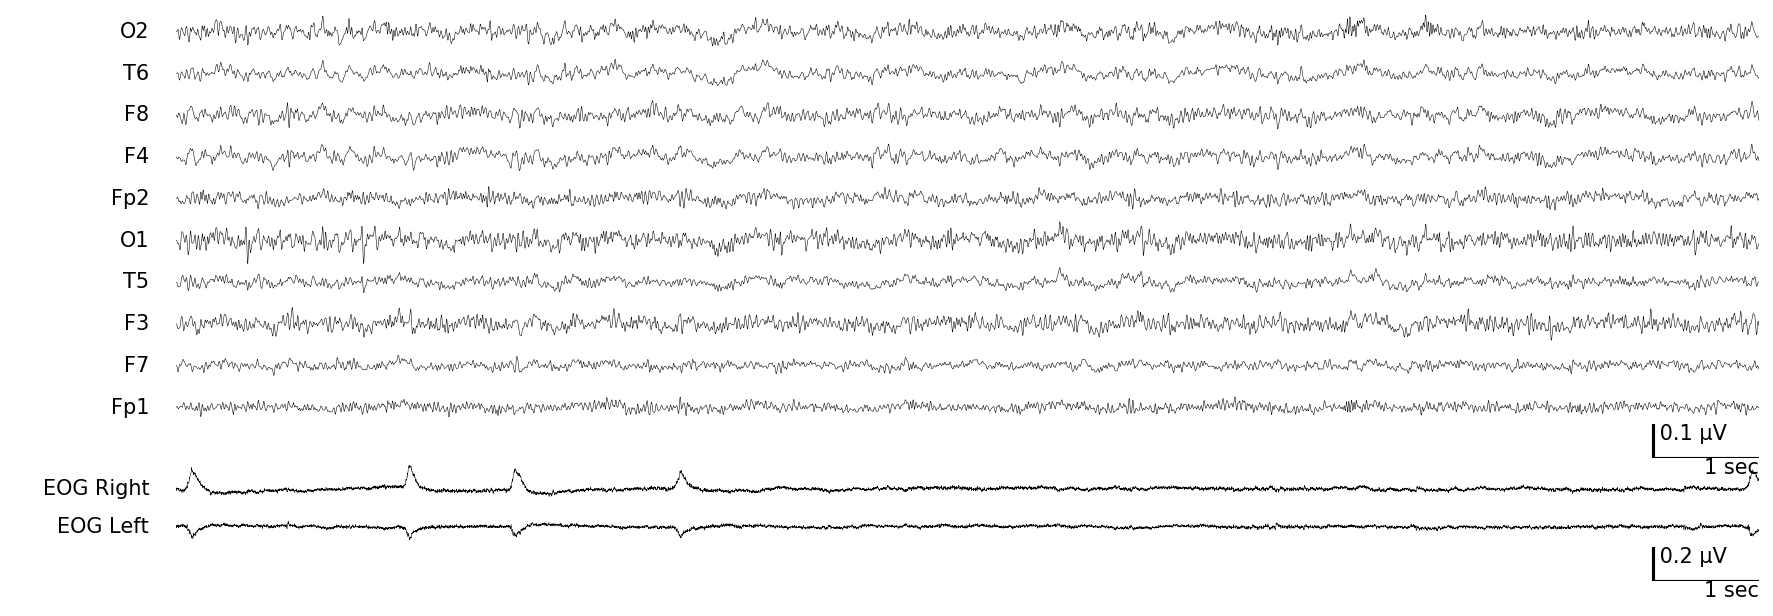

In [18]:
plot_sig(
    X = sample_raw_corrected.get_data() * 1e3,
    fs = 500,
    dpi = 150,
    unit = "μV",
    ch_names = sample_raw_corrected.ch_names,
    X_EOG = sample_raw_eog.get_data() * 1e3,
    eog_ch_names = sample_raw_eog.ch_names,
    eog_unit="μV",
    markers = [.3,2.2,3.3,4.9],scale=_scale_c*1e3
);